In [2]:
import os
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#from keras.models import Sequential, Model
#from keras.layers import Dense, Input
import datatable as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import joblib
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import os
from keras.models import load_model
import joblib
from sklearn.neural_network import MLPClassifier
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
PATH='/home/jm/SNUH/methylation/v2/compare/'


os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0, 1, 2, 3 중 하나
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # GPU 점유 비율
session = InteractiveSession(config=config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

                        

2023-06-07 11:31:01.225369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


2023-06-07 11:31:38.652581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19470 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
data=pd.read_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/35L33G.csv')
data['labels']='binding_Motif'

In [4]:
data=pd.read_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/35L33G.csv')
data['labels']='binding_Motif'
data1=pd.read_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/control.csv')

data1.columns=['results','labels']
data1['labels']='control'
data=pd.concat([data,data1])

In [5]:
df=data.drop_duplicates('results')
df=df.reset_index(drop=True)

In [6]:
df=df.reset_index(drop=True)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * (sequence_length - 4), 128)  # Adjust input size of fc1 layer
        self.fc2 = nn.Linear(128, 2)  # Assuming 2 classes for prediction

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Convert each DNA sequence to a one-hot encoded matrix
bases=['A','C','G','T']
encoded_matrices = []
for seq in df['results']:
    encoded_seq = []
    for base in seq:
        encoded_base = [int(base == b) for b in bases]
        encoded_seq.append(encoded_base)
    encoded_matrices.append(encoded_seq)

# Convert the list of matrices to a numpy array
encoded_matrices = np.array(encoded_matrices)

# Convert DataFrame to numpy arrays
labels = np.array(df['labels'].tolist())

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and validation sets
data_train, data_val, labels_train, labels_val = train_test_split(encoded_matrices, labels, test_size=0.2, random_state=42, stratify=labels)

# Create custom datasets
train_dataset = CustomDataset(data_train, labels_train)
val_dataset = CustomDataset(data_val, labels_val)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the CNN model
sequence_length = encoded_matrices.shape[1]  # Get sequence length
model = CNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        data = data.float().permute(0, 2, 1).to(device)  # Permute dimensions for proper input shape
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [8]:
from torch.nn.functional import softmax

In [9]:
model.eval()
predictions = []
predictions_prob = []
with torch.no_grad():
    for data, _ in val_loader:
        data = data.float().permute(0, 2, 1).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        prob=softmax(outputs.data, dim=1)
        predictions_prob.extend(prob.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

In [ ]:
label_encoder.inverse_transform(labels_val)

In [10]:
label_encoder.inverse_transform(predictions)

array(['binding_Motif', 'binding_Motif', 'binding_Motif', ..., 'control',
       'binding_Motif', 'binding_Motif'], dtype='<U13')

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, \
    classification_report, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics

In [12]:
print(metrics.classification_report(label_encoder.inverse_transform(predictions),
                                    label_encoder.inverse_transform(labels_val), digits=4))

               precision    recall  f1-score   support

binding_Motif     0.9698    0.9513    0.9605      4659
      control     0.3401    0.4588    0.3907       255

     accuracy                         0.9257      4914
    macro avg     0.6550    0.7051    0.6756      4914
 weighted avg     0.9371    0.9257    0.9309      4914



In [15]:
np.array(predictions_prob)[:,0]

array([1.        , 0.99997294, 1.        , ..., 0.00427856, 1.        ,
       1.        ], dtype=float32)

In [62]:
from sklearn.metrics import roc_curve, auc
roc_curve(predictions,np.array(predictions_prob)[:,0])

(array([0.        , 0.80200555, 0.82398122, 0.8337956 , 0.83955622,
        0.84382334, 0.84745039, 0.85043738, 0.85385108, 0.85619799,
        0.85833156, 0.8600384 , 0.86195861, 0.86537231, 0.86622573,
        0.86729251, 0.86899936, 0.86985278, 0.87049285, 0.87134628,
        0.87198635, 0.87326648, 0.87433326, 0.87518669, 0.8756134 ,
        0.87732025, 0.8775336 , 0.87796032, 0.87881374, 0.87924045,
        0.88052059, 0.8809473 , 0.88158737, 0.88222744, 0.88308086,
        0.88372093, 0.88393429, 0.88457435, 0.88500107, 0.88585449,
        0.8862812 , 0.88670792, 0.88692127, 0.88734798, 0.88756134,
        0.88820141, 0.88862812, 0.88884148, 0.89012161, 0.89033497,
        0.89097504, 0.89140175, 0.89204182, 0.89246853, 0.89289524,
        0.89353531, 0.89481545, 0.89545552, 0.89588223, 0.89630894,
        0.89801579, 0.89822914, 0.89865586, 0.89972264, 0.90057606,
        0.90228291, 0.90292298, 0.90313633, 0.9037764 , 0.90441647,
        0.90484318, 0.90740346, 0.90783017, 0.90

In [13]:
labels_val,np.array(predictions_prob)[:,1]

(array([0, 0, 0, ..., 0, 0, 0]),
 array([1.4530433e-13, 2.7084252e-05, 8.7893879e-09, ..., 9.9572146e-01,
        1.4209407e-21, 1.4899260e-32], dtype=float32))

In [69]:
a=pd.read_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/DNA_BERT_prob.csv')

In [20]:
pd.DataFrame(data=labels_val).to_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/answer.csv')
pd.DataFrame(np.array(predictions_prob)[:,1]).to_csv('/workspace/jaeminjeon_950515/SNUH/school/bioinfo1/one_hot_prob.csv')

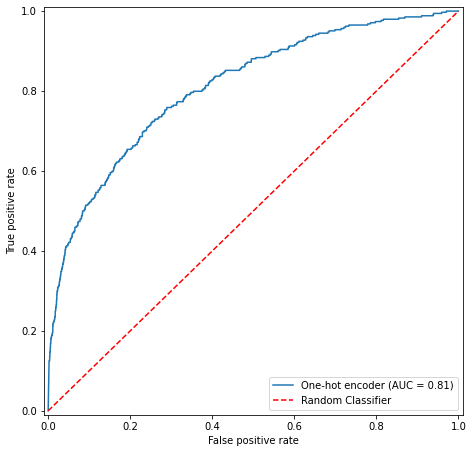

In [23]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline


#fpr3, tpr3, thresholds = roc_curve(labels_val,np.array(a.iloc[:,0]))
#roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds = roc_curve(labels_val,np.array(predictions_prob)[:,1])
roc_auc3 = auc(fpr3, tpr3)
 
fig, ax = plt.subplots(figsize=(7.5, 7.5))
 
#plt.plot(fpr2, tpr2, label='DNA BERT encoder (AUC = %0.2f)' % (roc_auc2))
plt.plot(fpr3, tpr3, label='One-hot encoder (AUC = %0.2f)' % (roc_auc3))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

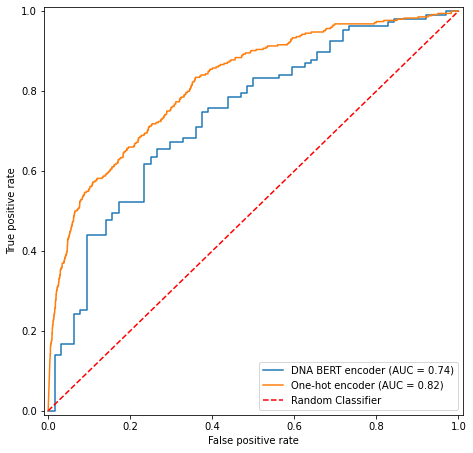

In [74]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline


fpr3, tpr3, thresholds = roc_curve(labels_val,np.array(a.iloc[:,0]))
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds = roc_curve(labels_val,np.array(predictions_prob)[:,1])
roc_auc3 = auc(fpr3, tpr3)
 
fig, ax = plt.subplots(figsize=(7.5, 7.5))
 
plt.plot(fpr2, tpr2, label='DNA BERT encoder (AUC = %0.2f)' % (roc_auc2))
plt.plot(fpr3, tpr3, label='One-hot encoder (AUC = %0.2f)' % (roc_auc3))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

In [59]:
auc(fpr3, tpr3)

1.0